In [1]:
import dlc_practical_prologue as prologue

In [2]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
# sometimes download directly will have the http403 error. If that happen, then use this code.
from six.moves import urllib
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
# load data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

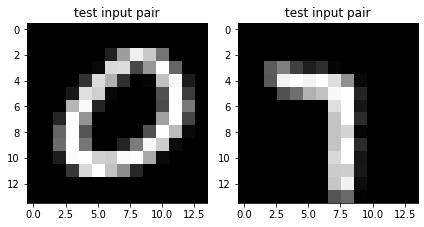

The test classes are: 0 and 7.
The test target is: 0


In [5]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [6]:
# understand the data of the training and testing data
print(train_input.shape)
print(train_input.dtype)
print(train_target.shape)
print(train_target.dtype)
print(train_classes.shape)
print(test_classes.shape)
print(train_classes[0])

torch.Size([1000, 2, 14, 14])
torch.float32
torch.Size([1000])
torch.int64
torch.Size([1000, 2])
torch.Size([1000, 2])
tensor([9, 3])


In [7]:
#weights_sharing_CNN
# What the weight sharing does is using both the 2000 images together to train the same layer, 
# which will be better than purely using 1000 images
class CNN_Net_weight_sharing_auxiliary_loss(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing_auxiliary_loss, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,kernel_size=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(20,200)
        self.fc4 = nn.Linear(200,200)
        self.fc5 = nn.Linear(200,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=3e-3)
    

    def forward(self, x):
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        
        # weight sharing
        img1 = F.relu(F.max_pool2d(self.bn1(self.conv1(img1)), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.bn2(self.conv2(img1)), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.bn1(self.conv1(img2)), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.bn2(self.conv2(img2)), kernel_size=2, stride=2))

#       detect the img1 figure 
        
        output1 = img1.view(-1,256)
        output1 = self.fc1(output1)
        output1 = F.dropout(output1,p=0.5,training=self.training)
        output1 = F.relu(output1)
        output1 = self.fc2(output1)
#       detect the img2 figure
        output2 = img2.view(-1,256)
        output2 = self.fc1(output2)
        output2 = F.dropout(output2,p=0.5,training=self.training)
        output2 = F.relu(output2)
        output2 = self.fc2(output2)
        
        output = torch.cat((output1,output2),1)      
        output = F.relu(F.dropout(self.fc3(output),p=0.5,training=self.training))
        output = F.relu(F.dropout(self.fc4(output),p=0.5,training=self.training))
        output = self.fc5(output)
        
        return output, output1, output2

        # Training Function with auxiliary_loss

    def trainer(self, train_input, train_target, train_classes, test_input, test_target, test_classes):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        :param train_classes: Training classes
        :param test_input: Testing features
        :param test_target: Training labels
        :output the loss plot
        """
        start_time = time.time()
#         self.train()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            # train mode
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
#                 get the output1,oytput2,and output
                output, output1, output2 = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
                class1 = train_classes[batch_idx:batch_idx+self.batch_size,0]
                class2 = train_classes[batch_idx:batch_idx+self.batch_size,1]
#                 auxiliary loss function
                loss = self.criterion(output, target)+0.5*self.criterion(output1, class1)+0.5*self.criterion(output2, class2)
                #gradients to zero
                self.optimizer.zero_grad()                          
                #backpropagation
                loss.backward() 
                self.optimizer.step()         
#                 every 50 batch_idx, output the loss
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted, train_output1, train_output2 = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)+0.5*self.criterion(train_output1, train_classes[:,0])+0.5*self.criterion(train_output2, train_classes[:,1])
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted, test_output1, test_output2 = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)+0.5*self.criterion(test_output1, test_classes[:,0])+0.5*self.criterion(test_output2, test_classes[:,1])
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)
            
            
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        # plot the accuracy and loss figure
            #Plotting the train and test loss and accuracy figure

        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        #Saving the plot
    #     ax2.figure.savefig(model.model_name+'accuracy.png')
        plt.savefig('accuracy_loss.png')

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set with batch_size
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        outputs,_,_ = self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)

    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        :output the model pth.
        """         
        torch.save(self, './model/'+ model_name)

In [8]:
# build an net instance
my_model=CNN_Net_weight_sharing_auxiliary_loss()
# save the model
my_model.save_model('CNN_Net_weight_sharing_auxiliary_loss.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 3.046886
Epoch: 001/025 | Batch 050/1000 | Loss: 3.039831
Epoch: 001/025 | Batch 100/1000 | Loss: 2.675135
Epoch: 001/025 | Batch 150/1000 | Loss: 2.687399
Epoch: 001/025 | Batch 200/1000 | Loss: 2.653729
Epoch: 001/025 | Batch 250/1000 | Loss: 2.420341
Epoch: 001/025 | Batch 300/1000 | Loss: 2.346017
Epoch: 001/025 | Batch 350/1000 | Loss: 2.103282
Epoch: 001/025 | Batch 400/1000 | Loss: 2.243946
Epoch: 001/025 | Batch 450/1000 | Loss: 2.014009
Epoch: 001/025 | Batch 500/1000 | Loss: 1.950356
Epoch: 001/025 | Batch 550/1000 | Loss: 1.780278
Epoch: 001/025 | Batch 600/1000 | Loss: 1.709639
Epoch: 001/025 | Batch 650/1000 | Loss: 1.655400
Epoch: 001/025 | Batch 700/1000 | Loss: 1.314652
Epoch: 001/025 | Batch 750/1000 | Loss: 1.621592
Epoch: 001/025 | Batch 800/1000 | Loss: 1.317756
Epoch: 001/025 | Batch 850/1000 | Loss: 1.534473
Epoch: 001/025 | Batch 900/1000 | Loss: 1.348756
Epoch: 001/025 | Batch 950/1000 | Loss: 1.050072
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 400/1000 | Loss: 0.311471
Epoch: 009/025 | Batch 450/1000 | Loss: 0.402768
Epoch: 009/025 | Batch 500/1000 | Loss: 0.493655
Epoch: 009/025 | Batch 550/1000 | Loss: 0.274823
Epoch: 009/025 | Batch 600/1000 | Loss: 0.230009
Epoch: 009/025 | Batch 650/1000 | Loss: 0.161448
Epoch: 009/025 | Batch 700/1000 | Loss: 0.188647
Epoch: 009/025 | Batch 750/1000 | Loss: 0.287820
Epoch: 009/025 | Batch 800/1000 | Loss: 0.232889
Epoch: 009/025 | Batch 850/1000 | Loss: 0.317371
Epoch: 009/025 | Batch 900/1000 | Loss: 0.235530
Epoch: 009/025 | Batch 950/1000 | Loss: 0.280336
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.408073
Epoch: 010/025 | Batch 050/1000 | Loss: 0.266663
Epoch: 010/025 | Batch 100/1000 | Loss: 0.212202
Epoch: 010/025 | Batch 150/1000 | Loss: 0.149020
Epoch: 010/025 | Batch 200/1000 | Loss: 0.211180
Epoch: 010/025 | Batch 250/1000 | Loss: 0.159972
Epoch: 010/025 | Batch 300/1000 | Loss: 0.319941
Epoch: 010/025 | Batch 350/1000 | Loss: 0.1497

Epoch: 017/025 | Batch 950/1000 | Loss: 0.272141
Time elapsed: 0.19 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.265209
Epoch: 018/025 | Batch 050/1000 | Loss: 0.067209
Epoch: 018/025 | Batch 100/1000 | Loss: 0.094241
Epoch: 018/025 | Batch 150/1000 | Loss: 0.062271
Epoch: 018/025 | Batch 200/1000 | Loss: 0.071690
Epoch: 018/025 | Batch 250/1000 | Loss: 0.101915
Epoch: 018/025 | Batch 300/1000 | Loss: 0.110690
Epoch: 018/025 | Batch 350/1000 | Loss: 0.208323
Epoch: 018/025 | Batch 400/1000 | Loss: 0.145662
Epoch: 018/025 | Batch 450/1000 | Loss: 0.106246
Epoch: 018/025 | Batch 500/1000 | Loss: 0.227600
Epoch: 018/025 | Batch 550/1000 | Loss: 0.257491
Epoch: 018/025 | Batch 600/1000 | Loss: 0.090185
Epoch: 018/025 | Batch 650/1000 | Loss: 0.280745
Epoch: 018/025 | Batch 700/1000 | Loss: 0.203096
Epoch: 018/025 | Batch 750/1000 | Loss: 0.106777
Epoch: 018/025 | Batch 800/1000 | Loss: 0.124434
Epoch: 018/025 | Batch 850/1000 | Loss: 0.151071
Epoch: 018/025 | Batch 900/1000 | Loss: 0.1337

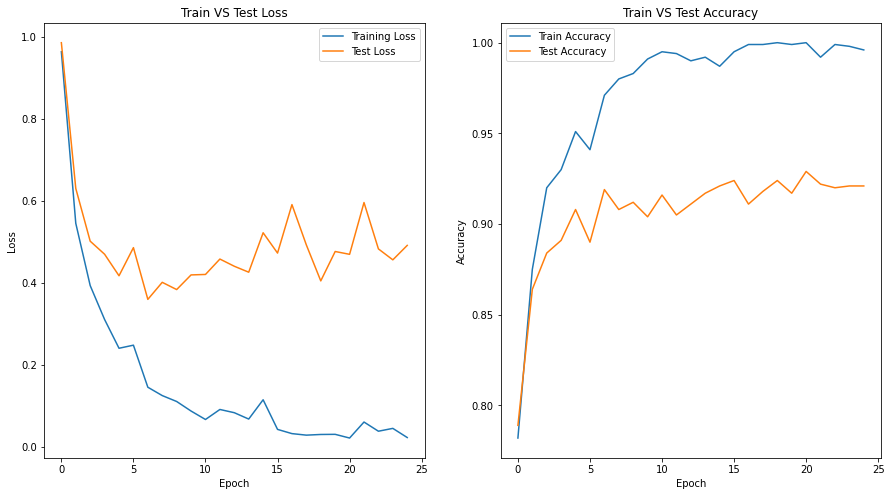

In [9]:
# train the model
my_model.trainer(train_input, train_target,train_classes, test_input, test_target,test_classes)

In [10]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 88268


Epoch: 001/025 | Batch 000/1000 | Loss: 3.031273
Epoch: 001/025 | Batch 050/1000 | Loss: 2.989126
Epoch: 001/025 | Batch 100/1000 | Loss: 2.789253
Epoch: 001/025 | Batch 150/1000 | Loss: 2.753510
Epoch: 001/025 | Batch 200/1000 | Loss: 2.658935
Epoch: 001/025 | Batch 250/1000 | Loss: 2.524008
Epoch: 001/025 | Batch 300/1000 | Loss: 2.359247
Epoch: 001/025 | Batch 350/1000 | Loss: 2.333930
Epoch: 001/025 | Batch 400/1000 | Loss: 2.328542
Epoch: 001/025 | Batch 450/1000 | Loss: 2.119975
Epoch: 001/025 | Batch 500/1000 | Loss: 2.021609
Epoch: 001/025 | Batch 550/1000 | Loss: 2.154016
Epoch: 001/025 | Batch 600/1000 | Loss: 1.944120
Epoch: 001/025 | Batch 650/1000 | Loss: 1.728607
Epoch: 001/025 | Batch 700/1000 | Loss: 1.904221
Epoch: 001/025 | Batch 750/1000 | Loss: 1.753914
Epoch: 001/025 | Batch 800/1000 | Loss: 1.532869
Epoch: 001/025 | Batch 850/1000 | Loss: 1.600725
Epoch: 001/025 | Batch 900/1000 | Loss: 1.639354
Epoch: 001/025 | Batch 950/1000 | Loss: 1.589493
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 450/1000 | Loss: 0.288302
Epoch: 009/025 | Batch 500/1000 | Loss: 0.384362
Epoch: 009/025 | Batch 550/1000 | Loss: 0.233695
Epoch: 009/025 | Batch 600/1000 | Loss: 0.229981
Epoch: 009/025 | Batch 650/1000 | Loss: 0.326124
Epoch: 009/025 | Batch 700/1000 | Loss: 0.237713
Epoch: 009/025 | Batch 750/1000 | Loss: 0.245263
Epoch: 009/025 | Batch 800/1000 | Loss: 0.340956
Epoch: 009/025 | Batch 850/1000 | Loss: 0.256419
Epoch: 009/025 | Batch 900/1000 | Loss: 0.344265
Epoch: 009/025 | Batch 950/1000 | Loss: 0.397457
Time elapsed: 0.10 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.290746
Epoch: 010/025 | Batch 050/1000 | Loss: 0.356686
Epoch: 010/025 | Batch 100/1000 | Loss: 0.346414
Epoch: 010/025 | Batch 150/1000 | Loss: 0.438841
Epoch: 010/025 | Batch 200/1000 | Loss: 0.217515
Epoch: 010/025 | Batch 250/1000 | Loss: 0.352103
Epoch: 010/025 | Batch 300/1000 | Loss: 0.216268
Epoch: 010/025 | Batch 350/1000 | Loss: 0.360456
Epoch: 010/025 | Batch 400/1000 | Loss: 0.3693

Epoch: 017/025 | Batch 950/1000 | Loss: 0.239197
Time elapsed: 0.19 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.070630
Epoch: 018/025 | Batch 050/1000 | Loss: 0.143379
Epoch: 018/025 | Batch 100/1000 | Loss: 0.401048
Epoch: 018/025 | Batch 150/1000 | Loss: 0.266004
Epoch: 018/025 | Batch 200/1000 | Loss: 0.132021
Epoch: 018/025 | Batch 250/1000 | Loss: 0.231381
Epoch: 018/025 | Batch 300/1000 | Loss: 0.157829
Epoch: 018/025 | Batch 350/1000 | Loss: 0.251312
Epoch: 018/025 | Batch 400/1000 | Loss: 0.334848
Epoch: 018/025 | Batch 450/1000 | Loss: 0.112107
Epoch: 018/025 | Batch 500/1000 | Loss: 0.129524
Epoch: 018/025 | Batch 550/1000 | Loss: 0.165006
Epoch: 018/025 | Batch 600/1000 | Loss: 0.299303
Epoch: 018/025 | Batch 650/1000 | Loss: 0.153346
Epoch: 018/025 | Batch 700/1000 | Loss: 0.177851
Epoch: 018/025 | Batch 750/1000 | Loss: 0.187434
Epoch: 018/025 | Batch 800/1000 | Loss: 0.114225
Epoch: 018/025 | Batch 850/1000 | Loss: 0.163749
Epoch: 018/025 | Batch 900/1000 | Loss: 0.3236

Epoch: 001/025 | Batch 500/1000 | Loss: 2.175668
Epoch: 001/025 | Batch 550/1000 | Loss: 1.893270
Epoch: 001/025 | Batch 600/1000 | Loss: 2.010412
Epoch: 001/025 | Batch 650/1000 | Loss: 1.874684
Epoch: 001/025 | Batch 700/1000 | Loss: 1.620870
Epoch: 001/025 | Batch 750/1000 | Loss: 1.743052
Epoch: 001/025 | Batch 800/1000 | Loss: 1.518607
Epoch: 001/025 | Batch 850/1000 | Loss: 1.491680
Epoch: 001/025 | Batch 900/1000 | Loss: 1.714545
Epoch: 001/025 | Batch 950/1000 | Loss: 1.468491
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.288501
Epoch: 002/025 | Batch 050/1000 | Loss: 1.537892
Epoch: 002/025 | Batch 100/1000 | Loss: 1.408490
Epoch: 002/025 | Batch 150/1000 | Loss: 1.201872
Epoch: 002/025 | Batch 200/1000 | Loss: 1.394593
Epoch: 002/025 | Batch 250/1000 | Loss: 1.351685
Epoch: 002/025 | Batch 300/1000 | Loss: 1.134447
Epoch: 002/025 | Batch 350/1000 | Loss: 1.101301
Epoch: 002/025 | Batch 400/1000 | Loss: 0.955859
Epoch: 002/025 | Batch 450/1000 | Loss: 1.1485

Epoch: 009/025 | Batch 750/1000 | Loss: 0.251135
Epoch: 009/025 | Batch 800/1000 | Loss: 0.223470
Epoch: 009/025 | Batch 850/1000 | Loss: 0.332395
Epoch: 009/025 | Batch 900/1000 | Loss: 0.418288
Epoch: 009/025 | Batch 950/1000 | Loss: 0.453659
Time elapsed: 0.13 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.296080
Epoch: 010/025 | Batch 050/1000 | Loss: 0.163166
Epoch: 010/025 | Batch 100/1000 | Loss: 0.221054
Epoch: 010/025 | Batch 150/1000 | Loss: 0.200492
Epoch: 010/025 | Batch 200/1000 | Loss: 0.189705
Epoch: 010/025 | Batch 250/1000 | Loss: 0.172372
Epoch: 010/025 | Batch 300/1000 | Loss: 0.263964
Epoch: 010/025 | Batch 350/1000 | Loss: 0.367778
Epoch: 010/025 | Batch 400/1000 | Loss: 0.263863
Epoch: 010/025 | Batch 450/1000 | Loss: 0.473416
Epoch: 010/025 | Batch 500/1000 | Loss: 0.519227
Epoch: 010/025 | Batch 550/1000 | Loss: 0.164717
Epoch: 010/025 | Batch 600/1000 | Loss: 0.425096
Epoch: 010/025 | Batch 650/1000 | Loss: 0.270376
Epoch: 010/025 | Batch 700/1000 | Loss: 0.2364

Time elapsed: 0.27 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.237644
Epoch: 018/025 | Batch 050/1000 | Loss: 0.090241
Epoch: 018/025 | Batch 100/1000 | Loss: 0.111178
Epoch: 018/025 | Batch 150/1000 | Loss: 0.109607
Epoch: 018/025 | Batch 200/1000 | Loss: 0.046796
Epoch: 018/025 | Batch 250/1000 | Loss: 0.106432
Epoch: 018/025 | Batch 300/1000 | Loss: 0.128749
Epoch: 018/025 | Batch 350/1000 | Loss: 0.186317
Epoch: 018/025 | Batch 400/1000 | Loss: 0.134331
Epoch: 018/025 | Batch 450/1000 | Loss: 0.104045
Epoch: 018/025 | Batch 500/1000 | Loss: 0.156410
Epoch: 018/025 | Batch 550/1000 | Loss: 0.059077
Epoch: 018/025 | Batch 600/1000 | Loss: 0.491697
Epoch: 018/025 | Batch 650/1000 | Loss: 0.184699
Epoch: 018/025 | Batch 700/1000 | Loss: 0.265706
Epoch: 018/025 | Batch 750/1000 | Loss: 0.142399
Epoch: 018/025 | Batch 800/1000 | Loss: 0.294848
Epoch: 018/025 | Batch 850/1000 | Loss: 0.142883
Epoch: 018/025 | Batch 900/1000 | Loss: 0.159401
Epoch: 018/025 | Batch 950/1000 | Loss: 0.4669

Epoch: 001/025 | Batch 400/1000 | Loss: 2.105080
Epoch: 001/025 | Batch 450/1000 | Loss: 2.044101
Epoch: 001/025 | Batch 500/1000 | Loss: 1.949735
Epoch: 001/025 | Batch 550/1000 | Loss: 1.887753
Epoch: 001/025 | Batch 600/1000 | Loss: 1.639560
Epoch: 001/025 | Batch 650/1000 | Loss: 1.790492
Epoch: 001/025 | Batch 700/1000 | Loss: 1.892288
Epoch: 001/025 | Batch 750/1000 | Loss: 1.509447
Epoch: 001/025 | Batch 800/1000 | Loss: 1.382023
Epoch: 001/025 | Batch 850/1000 | Loss: 1.330174
Epoch: 001/025 | Batch 900/1000 | Loss: 1.322302
Epoch: 001/025 | Batch 950/1000 | Loss: 1.521971
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.264077
Epoch: 002/025 | Batch 050/1000 | Loss: 1.530183
Epoch: 002/025 | Batch 100/1000 | Loss: 1.257493
Epoch: 002/025 | Batch 150/1000 | Loss: 0.951880
Epoch: 002/025 | Batch 200/1000 | Loss: 1.100241
Epoch: 002/025 | Batch 250/1000 | Loss: 1.322661
Epoch: 002/025 | Batch 300/1000 | Loss: 1.097804
Epoch: 002/025 | Batch 350/1000 | Loss: 1.2375

Epoch: 009/025 | Batch 850/1000 | Loss: 0.263844
Epoch: 009/025 | Batch 900/1000 | Loss: 0.168265
Epoch: 009/025 | Batch 950/1000 | Loss: 0.239966
Time elapsed: 0.12 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.207568
Epoch: 010/025 | Batch 050/1000 | Loss: 0.217168
Epoch: 010/025 | Batch 100/1000 | Loss: 0.131763
Epoch: 010/025 | Batch 150/1000 | Loss: 0.158664
Epoch: 010/025 | Batch 200/1000 | Loss: 0.383695
Epoch: 010/025 | Batch 250/1000 | Loss: 0.265947
Epoch: 010/025 | Batch 300/1000 | Loss: 0.221906
Epoch: 010/025 | Batch 350/1000 | Loss: 0.298663
Epoch: 010/025 | Batch 400/1000 | Loss: 0.422057
Epoch: 010/025 | Batch 450/1000 | Loss: 0.313092
Epoch: 010/025 | Batch 500/1000 | Loss: 0.157351
Epoch: 010/025 | Batch 550/1000 | Loss: 0.176472
Epoch: 010/025 | Batch 600/1000 | Loss: 0.281515
Epoch: 010/025 | Batch 650/1000 | Loss: 0.250088
Epoch: 010/025 | Batch 700/1000 | Loss: 0.328513
Epoch: 010/025 | Batch 750/1000 | Loss: 0.424684
Epoch: 010/025 | Batch 800/1000 | Loss: 0.2475

Epoch: 018/025 | Batch 350/1000 | Loss: 0.135010
Epoch: 018/025 | Batch 400/1000 | Loss: 0.262401
Epoch: 018/025 | Batch 450/1000 | Loss: 0.127422
Epoch: 018/025 | Batch 500/1000 | Loss: 0.229074
Epoch: 018/025 | Batch 550/1000 | Loss: 0.206795
Epoch: 018/025 | Batch 600/1000 | Loss: 0.154151
Epoch: 018/025 | Batch 650/1000 | Loss: 0.175598
Epoch: 018/025 | Batch 700/1000 | Loss: 0.337996
Epoch: 018/025 | Batch 750/1000 | Loss: 0.144435
Epoch: 018/025 | Batch 800/1000 | Loss: 0.156689
Epoch: 018/025 | Batch 850/1000 | Loss: 0.336526
Epoch: 018/025 | Batch 900/1000 | Loss: 0.072736
Epoch: 018/025 | Batch 950/1000 | Loss: 0.124942
Time elapsed: 0.24 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.143220
Epoch: 019/025 | Batch 050/1000 | Loss: 0.165985
Epoch: 019/025 | Batch 100/1000 | Loss: 0.262643
Epoch: 019/025 | Batch 150/1000 | Loss: 0.175330
Epoch: 019/025 | Batch 200/1000 | Loss: 0.157822
Epoch: 019/025 | Batch 250/1000 | Loss: 0.309096
Epoch: 019/025 | Batch 300/1000 | Loss: 0.0782

Epoch: 001/025 | Batch 800/1000 | Loss: 1.574568
Epoch: 001/025 | Batch 850/1000 | Loss: 1.695873
Epoch: 001/025 | Batch 900/1000 | Loss: 1.666644
Epoch: 001/025 | Batch 950/1000 | Loss: 1.386499
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.287330
Epoch: 002/025 | Batch 050/1000 | Loss: 1.272296
Epoch: 002/025 | Batch 100/1000 | Loss: 1.472039
Epoch: 002/025 | Batch 150/1000 | Loss: 1.244072
Epoch: 002/025 | Batch 200/1000 | Loss: 1.080374
Epoch: 002/025 | Batch 250/1000 | Loss: 1.236008
Epoch: 002/025 | Batch 300/1000 | Loss: 1.286855
Epoch: 002/025 | Batch 350/1000 | Loss: 1.413861
Epoch: 002/025 | Batch 400/1000 | Loss: 1.224748
Epoch: 002/025 | Batch 450/1000 | Loss: 1.063039
Epoch: 002/025 | Batch 500/1000 | Loss: 1.112856
Epoch: 002/025 | Batch 550/1000 | Loss: 1.235597
Epoch: 002/025 | Batch 600/1000 | Loss: 1.025718
Epoch: 002/025 | Batch 650/1000 | Loss: 0.988747
Epoch: 002/025 | Batch 700/1000 | Loss: 1.174300
Epoch: 002/025 | Batch 750/1000 | Loss: 1.0444

Time elapsed: 0.14 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.326367
Epoch: 010/025 | Batch 050/1000 | Loss: 0.208891
Epoch: 010/025 | Batch 100/1000 | Loss: 0.239536
Epoch: 010/025 | Batch 150/1000 | Loss: 0.325003
Epoch: 010/025 | Batch 200/1000 | Loss: 0.284074
Epoch: 010/025 | Batch 250/1000 | Loss: 0.213636
Epoch: 010/025 | Batch 300/1000 | Loss: 0.333276
Epoch: 010/025 | Batch 350/1000 | Loss: 0.272121
Epoch: 010/025 | Batch 400/1000 | Loss: 0.243938
Epoch: 010/025 | Batch 450/1000 | Loss: 0.167682
Epoch: 010/025 | Batch 500/1000 | Loss: 0.556784
Epoch: 010/025 | Batch 550/1000 | Loss: 0.169794
Epoch: 010/025 | Batch 600/1000 | Loss: 0.486675
Epoch: 010/025 | Batch 650/1000 | Loss: 0.089120
Epoch: 010/025 | Batch 700/1000 | Loss: 0.225868
Epoch: 010/025 | Batch 750/1000 | Loss: 0.185788
Epoch: 010/025 | Batch 800/1000 | Loss: 0.231759
Epoch: 010/025 | Batch 850/1000 | Loss: 0.283358
Epoch: 010/025 | Batch 900/1000 | Loss: 0.259125
Epoch: 010/025 | Batch 950/1000 | Loss: 0.1479

Epoch: 018/025 | Batch 300/1000 | Loss: 0.198734
Epoch: 018/025 | Batch 350/1000 | Loss: 0.135282
Epoch: 018/025 | Batch 400/1000 | Loss: 0.115190
Epoch: 018/025 | Batch 450/1000 | Loss: 0.134277
Epoch: 018/025 | Batch 500/1000 | Loss: 0.444382
Epoch: 018/025 | Batch 550/1000 | Loss: 0.129583
Epoch: 018/025 | Batch 600/1000 | Loss: 0.165568
Epoch: 018/025 | Batch 650/1000 | Loss: 0.136712
Epoch: 018/025 | Batch 700/1000 | Loss: 0.202161
Epoch: 018/025 | Batch 750/1000 | Loss: 0.250338
Epoch: 018/025 | Batch 800/1000 | Loss: 0.171865
Epoch: 018/025 | Batch 850/1000 | Loss: 0.206726
Epoch: 018/025 | Batch 900/1000 | Loss: 0.119592
Epoch: 018/025 | Batch 950/1000 | Loss: 0.131125
Time elapsed: 0.28 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.250470
Epoch: 019/025 | Batch 050/1000 | Loss: 0.091990
Epoch: 019/025 | Batch 100/1000 | Loss: 0.180588
Epoch: 019/025 | Batch 150/1000 | Loss: 0.123282
Epoch: 019/025 | Batch 200/1000 | Loss: 0.193413
Epoch: 019/025 | Batch 250/1000 | Loss: 0.1663

Epoch: 001/025 | Batch 850/1000 | Loss: 1.622474
Epoch: 001/025 | Batch 900/1000 | Loss: 1.575089
Epoch: 001/025 | Batch 950/1000 | Loss: 1.319595
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.524719
Epoch: 002/025 | Batch 050/1000 | Loss: 1.364292
Epoch: 002/025 | Batch 100/1000 | Loss: 1.380940
Epoch: 002/025 | Batch 150/1000 | Loss: 1.367992
Epoch: 002/025 | Batch 200/1000 | Loss: 1.258737
Epoch: 002/025 | Batch 250/1000 | Loss: 1.070537
Epoch: 002/025 | Batch 300/1000 | Loss: 1.128383
Epoch: 002/025 | Batch 350/1000 | Loss: 1.046552
Epoch: 002/025 | Batch 400/1000 | Loss: 1.083237
Epoch: 002/025 | Batch 450/1000 | Loss: 1.060633
Epoch: 002/025 | Batch 500/1000 | Loss: 0.963755
Epoch: 002/025 | Batch 550/1000 | Loss: 0.962779
Epoch: 002/025 | Batch 600/1000 | Loss: 1.122047
Epoch: 002/025 | Batch 650/1000 | Loss: 0.789108
Epoch: 002/025 | Batch 700/1000 | Loss: 0.857187
Epoch: 002/025 | Batch 750/1000 | Loss: 0.898277
Epoch: 002/025 | Batch 800/1000 | Loss: 0.8326

Epoch: 010/025 | Batch 350/1000 | Loss: 0.298731
Epoch: 010/025 | Batch 400/1000 | Loss: 0.201410
Epoch: 010/025 | Batch 450/1000 | Loss: 0.254907
Epoch: 010/025 | Batch 500/1000 | Loss: 0.353690
Epoch: 010/025 | Batch 550/1000 | Loss: 0.164233
Epoch: 010/025 | Batch 600/1000 | Loss: 0.240359
Epoch: 010/025 | Batch 650/1000 | Loss: 0.242500
Epoch: 010/025 | Batch 700/1000 | Loss: 0.276785
Epoch: 010/025 | Batch 750/1000 | Loss: 0.206599
Epoch: 010/025 | Batch 800/1000 | Loss: 0.360740
Epoch: 010/025 | Batch 850/1000 | Loss: 0.203034
Epoch: 010/025 | Batch 900/1000 | Loss: 0.216336
Epoch: 010/025 | Batch 950/1000 | Loss: 0.200449
Time elapsed: 0.15 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.334856
Epoch: 011/025 | Batch 050/1000 | Loss: 0.270523
Epoch: 011/025 | Batch 100/1000 | Loss: 0.280215
Epoch: 011/025 | Batch 150/1000 | Loss: 0.279925
Epoch: 011/025 | Batch 200/1000 | Loss: 0.353416
Epoch: 011/025 | Batch 250/1000 | Loss: 0.226346
Epoch: 011/025 | Batch 300/1000 | Loss: 0.2758

Epoch: 018/025 | Batch 650/1000 | Loss: 0.048046
Epoch: 018/025 | Batch 700/1000 | Loss: 0.133677
Epoch: 018/025 | Batch 750/1000 | Loss: 0.064533
Epoch: 018/025 | Batch 800/1000 | Loss: 0.208523
Epoch: 018/025 | Batch 850/1000 | Loss: 0.190662
Epoch: 018/025 | Batch 900/1000 | Loss: 0.224773
Epoch: 018/025 | Batch 950/1000 | Loss: 0.201948
Time elapsed: 0.28 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.177579
Epoch: 019/025 | Batch 050/1000 | Loss: 0.120503
Epoch: 019/025 | Batch 100/1000 | Loss: 0.183008
Epoch: 019/025 | Batch 150/1000 | Loss: 0.226647
Epoch: 019/025 | Batch 200/1000 | Loss: 0.184966
Epoch: 019/025 | Batch 250/1000 | Loss: 0.093408
Epoch: 019/025 | Batch 300/1000 | Loss: 0.225646
Epoch: 019/025 | Batch 350/1000 | Loss: 0.082029
Epoch: 019/025 | Batch 400/1000 | Loss: 0.448793
Epoch: 019/025 | Batch 450/1000 | Loss: 0.143433
Epoch: 019/025 | Batch 500/1000 | Loss: 0.162161
Epoch: 019/025 | Batch 550/1000 | Loss: 0.273408
Epoch: 019/025 | Batch 600/1000 | Loss: 0.1913

Epoch: 001/025 | Batch 800/1000 | Loss: 1.604228
Epoch: 001/025 | Batch 850/1000 | Loss: 1.724258
Epoch: 001/025 | Batch 900/1000 | Loss: 1.507117
Epoch: 001/025 | Batch 950/1000 | Loss: 1.551124
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.447103
Epoch: 002/025 | Batch 050/1000 | Loss: 1.232201
Epoch: 002/025 | Batch 100/1000 | Loss: 1.380005
Epoch: 002/025 | Batch 150/1000 | Loss: 1.335385
Epoch: 002/025 | Batch 200/1000 | Loss: 1.341910
Epoch: 002/025 | Batch 250/1000 | Loss: 1.339951
Epoch: 002/025 | Batch 300/1000 | Loss: 1.039222
Epoch: 002/025 | Batch 350/1000 | Loss: 1.251201
Epoch: 002/025 | Batch 400/1000 | Loss: 1.155082
Epoch: 002/025 | Batch 450/1000 | Loss: 1.096251
Epoch: 002/025 | Batch 500/1000 | Loss: 0.990195
Epoch: 002/025 | Batch 550/1000 | Loss: 1.019924
Epoch: 002/025 | Batch 600/1000 | Loss: 1.062959
Epoch: 002/025 | Batch 650/1000 | Loss: 1.069771
Epoch: 002/025 | Batch 700/1000 | Loss: 0.942550
Epoch: 002/025 | Batch 750/1000 | Loss: 0.8666

Time elapsed: 0.14 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.189698
Epoch: 010/025 | Batch 050/1000 | Loss: 0.188442
Epoch: 010/025 | Batch 100/1000 | Loss: 0.177750
Epoch: 010/025 | Batch 150/1000 | Loss: 0.226903
Epoch: 010/025 | Batch 200/1000 | Loss: 0.093771
Epoch: 010/025 | Batch 250/1000 | Loss: 0.346985
Epoch: 010/025 | Batch 300/1000 | Loss: 0.236653
Epoch: 010/025 | Batch 350/1000 | Loss: 0.388783
Epoch: 010/025 | Batch 400/1000 | Loss: 0.236427
Epoch: 010/025 | Batch 450/1000 | Loss: 0.305870
Epoch: 010/025 | Batch 500/1000 | Loss: 0.191605
Epoch: 010/025 | Batch 550/1000 | Loss: 0.160859
Epoch: 010/025 | Batch 600/1000 | Loss: 0.166504
Epoch: 010/025 | Batch 650/1000 | Loss: 0.226914
Epoch: 010/025 | Batch 700/1000 | Loss: 0.200334
Epoch: 010/025 | Batch 750/1000 | Loss: 0.299045
Epoch: 010/025 | Batch 800/1000 | Loss: 0.254713
Epoch: 010/025 | Batch 850/1000 | Loss: 0.201061
Epoch: 010/025 | Batch 900/1000 | Loss: 0.146598
Epoch: 010/025 | Batch 950/1000 | Loss: 0.1682

Epoch: 018/025 | Batch 350/1000 | Loss: 0.190179
Epoch: 018/025 | Batch 400/1000 | Loss: 0.113766
Epoch: 018/025 | Batch 450/1000 | Loss: 0.195965
Epoch: 018/025 | Batch 500/1000 | Loss: 0.069534
Epoch: 018/025 | Batch 550/1000 | Loss: 0.286616
Epoch: 018/025 | Batch 600/1000 | Loss: 0.144759
Epoch: 018/025 | Batch 650/1000 | Loss: 0.132502
Epoch: 018/025 | Batch 700/1000 | Loss: 0.263164
Epoch: 018/025 | Batch 750/1000 | Loss: 0.309610
Epoch: 018/025 | Batch 800/1000 | Loss: 0.187997
Epoch: 018/025 | Batch 850/1000 | Loss: 0.134962
Epoch: 018/025 | Batch 900/1000 | Loss: 0.128639
Epoch: 018/025 | Batch 950/1000 | Loss: 0.218392
Time elapsed: 0.29 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.416079
Epoch: 019/025 | Batch 050/1000 | Loss: 0.081171
Epoch: 019/025 | Batch 100/1000 | Loss: 0.094172
Epoch: 019/025 | Batch 150/1000 | Loss: 0.165118
Epoch: 019/025 | Batch 200/1000 | Loss: 0.215179
Epoch: 019/025 | Batch 250/1000 | Loss: 0.181505
Epoch: 019/025 | Batch 300/1000 | Loss: 0.2559

Epoch: 001/025 | Batch 800/1000 | Loss: 1.595852
Epoch: 001/025 | Batch 850/1000 | Loss: 1.330381
Epoch: 001/025 | Batch 900/1000 | Loss: 1.354989
Epoch: 001/025 | Batch 950/1000 | Loss: 1.453675
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.166812
Epoch: 002/025 | Batch 050/1000 | Loss: 1.245773
Epoch: 002/025 | Batch 100/1000 | Loss: 1.094307
Epoch: 002/025 | Batch 150/1000 | Loss: 1.309037
Epoch: 002/025 | Batch 200/1000 | Loss: 1.237840
Epoch: 002/025 | Batch 250/1000 | Loss: 1.254504
Epoch: 002/025 | Batch 300/1000 | Loss: 1.097882
Epoch: 002/025 | Batch 350/1000 | Loss: 1.206661
Epoch: 002/025 | Batch 400/1000 | Loss: 1.077247
Epoch: 002/025 | Batch 450/1000 | Loss: 0.837362
Epoch: 002/025 | Batch 500/1000 | Loss: 1.178098
Epoch: 002/025 | Batch 550/1000 | Loss: 1.153968
Epoch: 002/025 | Batch 600/1000 | Loss: 1.185789
Epoch: 002/025 | Batch 650/1000 | Loss: 0.860014
Epoch: 002/025 | Batch 700/1000 | Loss: 1.280929
Epoch: 002/025 | Batch 750/1000 | Loss: 0.9182

Time elapsed: 0.14 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.262125
Epoch: 010/025 | Batch 050/1000 | Loss: 0.397570
Epoch: 010/025 | Batch 100/1000 | Loss: 0.348406
Epoch: 010/025 | Batch 150/1000 | Loss: 0.207727
Epoch: 010/025 | Batch 200/1000 | Loss: 0.343655
Epoch: 010/025 | Batch 250/1000 | Loss: 0.258602
Epoch: 010/025 | Batch 300/1000 | Loss: 0.222911
Epoch: 010/025 | Batch 350/1000 | Loss: 0.279702
Epoch: 010/025 | Batch 400/1000 | Loss: 0.245438
Epoch: 010/025 | Batch 450/1000 | Loss: 0.132480
Epoch: 010/025 | Batch 500/1000 | Loss: 0.322763
Epoch: 010/025 | Batch 550/1000 | Loss: 0.432754
Epoch: 010/025 | Batch 600/1000 | Loss: 0.440160
Epoch: 010/025 | Batch 650/1000 | Loss: 0.193224
Epoch: 010/025 | Batch 700/1000 | Loss: 0.357539
Epoch: 010/025 | Batch 750/1000 | Loss: 0.401850
Epoch: 010/025 | Batch 800/1000 | Loss: 0.309425
Epoch: 010/025 | Batch 850/1000 | Loss: 0.341726
Epoch: 010/025 | Batch 900/1000 | Loss: 0.263931
Epoch: 010/025 | Batch 950/1000 | Loss: 0.4407

Epoch: 018/025 | Batch 350/1000 | Loss: 0.222071
Epoch: 018/025 | Batch 400/1000 | Loss: 0.354986
Epoch: 018/025 | Batch 450/1000 | Loss: 0.182177
Epoch: 018/025 | Batch 500/1000 | Loss: 0.196890
Epoch: 018/025 | Batch 550/1000 | Loss: 0.321151
Epoch: 018/025 | Batch 600/1000 | Loss: 0.072395
Epoch: 018/025 | Batch 650/1000 | Loss: 0.357345
Epoch: 018/025 | Batch 700/1000 | Loss: 0.329479
Epoch: 018/025 | Batch 750/1000 | Loss: 0.128207
Epoch: 018/025 | Batch 800/1000 | Loss: 0.279317
Epoch: 018/025 | Batch 850/1000 | Loss: 0.179767
Epoch: 018/025 | Batch 900/1000 | Loss: 0.093697
Epoch: 018/025 | Batch 950/1000 | Loss: 0.231600
Time elapsed: 0.28 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.142812
Epoch: 019/025 | Batch 050/1000 | Loss: 0.367031
Epoch: 019/025 | Batch 100/1000 | Loss: 0.204093
Epoch: 019/025 | Batch 150/1000 | Loss: 0.189685
Epoch: 019/025 | Batch 200/1000 | Loss: 0.271592
Epoch: 019/025 | Batch 250/1000 | Loss: 0.164346
Epoch: 019/025 | Batch 300/1000 | Loss: 0.1681

Epoch: 001/025 | Batch 800/1000 | Loss: 1.412852
Epoch: 001/025 | Batch 850/1000 | Loss: 1.799033
Epoch: 001/025 | Batch 900/1000 | Loss: 1.543350
Epoch: 001/025 | Batch 950/1000 | Loss: 1.477255
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.248881
Epoch: 002/025 | Batch 050/1000 | Loss: 1.338548
Epoch: 002/025 | Batch 100/1000 | Loss: 1.313628
Epoch: 002/025 | Batch 150/1000 | Loss: 1.316453
Epoch: 002/025 | Batch 200/1000 | Loss: 1.422487
Epoch: 002/025 | Batch 250/1000 | Loss: 1.154753
Epoch: 002/025 | Batch 300/1000 | Loss: 1.111502
Epoch: 002/025 | Batch 350/1000 | Loss: 1.183778
Epoch: 002/025 | Batch 400/1000 | Loss: 1.374103
Epoch: 002/025 | Batch 450/1000 | Loss: 1.022329
Epoch: 002/025 | Batch 500/1000 | Loss: 1.203987
Epoch: 002/025 | Batch 550/1000 | Loss: 1.154911
Epoch: 002/025 | Batch 600/1000 | Loss: 1.136157
Epoch: 002/025 | Batch 650/1000 | Loss: 0.805537
Epoch: 002/025 | Batch 700/1000 | Loss: 0.921990
Epoch: 002/025 | Batch 750/1000 | Loss: 0.9968

Time elapsed: 0.13 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.363632
Epoch: 010/025 | Batch 050/1000 | Loss: 0.321117
Epoch: 010/025 | Batch 100/1000 | Loss: 0.394610
Epoch: 010/025 | Batch 150/1000 | Loss: 0.214357
Epoch: 010/025 | Batch 200/1000 | Loss: 0.225133
Epoch: 010/025 | Batch 250/1000 | Loss: 0.270907
Epoch: 010/025 | Batch 300/1000 | Loss: 0.162432
Epoch: 010/025 | Batch 350/1000 | Loss: 0.250657
Epoch: 010/025 | Batch 400/1000 | Loss: 0.298394
Epoch: 010/025 | Batch 450/1000 | Loss: 0.171693
Epoch: 010/025 | Batch 500/1000 | Loss: 0.187867
Epoch: 010/025 | Batch 550/1000 | Loss: 0.272084
Epoch: 010/025 | Batch 600/1000 | Loss: 0.283431
Epoch: 010/025 | Batch 650/1000 | Loss: 0.072679
Epoch: 010/025 | Batch 700/1000 | Loss: 0.128116
Epoch: 010/025 | Batch 750/1000 | Loss: 0.299156
Epoch: 010/025 | Batch 800/1000 | Loss: 0.202499
Epoch: 010/025 | Batch 850/1000 | Loss: 0.224971
Epoch: 010/025 | Batch 900/1000 | Loss: 0.219815
Epoch: 010/025 | Batch 950/1000 | Loss: 0.2708

Epoch: 018/025 | Batch 350/1000 | Loss: 0.235003
Epoch: 018/025 | Batch 400/1000 | Loss: 0.215128
Epoch: 018/025 | Batch 450/1000 | Loss: 0.103436
Epoch: 018/025 | Batch 500/1000 | Loss: 0.125834
Epoch: 018/025 | Batch 550/1000 | Loss: 0.127006
Epoch: 018/025 | Batch 600/1000 | Loss: 0.195551
Epoch: 018/025 | Batch 650/1000 | Loss: 0.106585
Epoch: 018/025 | Batch 700/1000 | Loss: 0.103449
Epoch: 018/025 | Batch 750/1000 | Loss: 0.160516
Epoch: 018/025 | Batch 800/1000 | Loss: 0.220247
Epoch: 018/025 | Batch 850/1000 | Loss: 0.242620
Epoch: 018/025 | Batch 900/1000 | Loss: 0.128276
Epoch: 018/025 | Batch 950/1000 | Loss: 0.265032
Time elapsed: 0.27 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.114014
Epoch: 019/025 | Batch 050/1000 | Loss: 0.086828
Epoch: 019/025 | Batch 100/1000 | Loss: 0.534883
Epoch: 019/025 | Batch 150/1000 | Loss: 0.104111
Epoch: 019/025 | Batch 200/1000 | Loss: 0.237039
Epoch: 019/025 | Batch 250/1000 | Loss: 0.169339
Epoch: 019/025 | Batch 300/1000 | Loss: 0.1321

Epoch: 001/025 | Batch 800/1000 | Loss: 1.776133
Epoch: 001/025 | Batch 850/1000 | Loss: 1.735098
Epoch: 001/025 | Batch 900/1000 | Loss: 1.520205
Epoch: 001/025 | Batch 950/1000 | Loss: 1.497403
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.540456
Epoch: 002/025 | Batch 050/1000 | Loss: 1.394029
Epoch: 002/025 | Batch 100/1000 | Loss: 1.523102
Epoch: 002/025 | Batch 150/1000 | Loss: 1.238128
Epoch: 002/025 | Batch 200/1000 | Loss: 1.322370
Epoch: 002/025 | Batch 250/1000 | Loss: 1.406505
Epoch: 002/025 | Batch 300/1000 | Loss: 1.083828
Epoch: 002/025 | Batch 350/1000 | Loss: 1.146096
Epoch: 002/025 | Batch 400/1000 | Loss: 1.289527
Epoch: 002/025 | Batch 450/1000 | Loss: 0.941425
Epoch: 002/025 | Batch 500/1000 | Loss: 1.325154
Epoch: 002/025 | Batch 550/1000 | Loss: 1.188481
Epoch: 002/025 | Batch 600/1000 | Loss: 1.104602
Epoch: 002/025 | Batch 650/1000 | Loss: 1.189721
Epoch: 002/025 | Batch 700/1000 | Loss: 1.133297
Epoch: 002/025 | Batch 750/1000 | Loss: 0.9828

Time elapsed: 0.14 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.307878
Epoch: 010/025 | Batch 050/1000 | Loss: 0.364382
Epoch: 010/025 | Batch 100/1000 | Loss: 0.407265
Epoch: 010/025 | Batch 150/1000 | Loss: 0.227349
Epoch: 010/025 | Batch 200/1000 | Loss: 0.186012
Epoch: 010/025 | Batch 250/1000 | Loss: 0.383974
Epoch: 010/025 | Batch 300/1000 | Loss: 0.341832
Epoch: 010/025 | Batch 350/1000 | Loss: 0.274596
Epoch: 010/025 | Batch 400/1000 | Loss: 0.314619
Epoch: 010/025 | Batch 450/1000 | Loss: 0.188615
Epoch: 010/025 | Batch 500/1000 | Loss: 0.390830
Epoch: 010/025 | Batch 550/1000 | Loss: 0.330859
Epoch: 010/025 | Batch 600/1000 | Loss: 0.231155
Epoch: 010/025 | Batch 650/1000 | Loss: 0.284903
Epoch: 010/025 | Batch 700/1000 | Loss: 0.427322
Epoch: 010/025 | Batch 750/1000 | Loss: 0.258054
Epoch: 010/025 | Batch 800/1000 | Loss: 0.290122
Epoch: 010/025 | Batch 850/1000 | Loss: 0.263971
Epoch: 010/025 | Batch 900/1000 | Loss: 0.243407
Epoch: 010/025 | Batch 950/1000 | Loss: 0.2519

Epoch: 018/025 | Batch 350/1000 | Loss: 0.119463
Epoch: 018/025 | Batch 400/1000 | Loss: 0.280287
Epoch: 018/025 | Batch 450/1000 | Loss: 0.289832
Epoch: 018/025 | Batch 500/1000 | Loss: 0.221598
Epoch: 018/025 | Batch 550/1000 | Loss: 0.162840
Epoch: 018/025 | Batch 600/1000 | Loss: 0.291020
Epoch: 018/025 | Batch 650/1000 | Loss: 0.187876
Epoch: 018/025 | Batch 700/1000 | Loss: 0.118134
Epoch: 018/025 | Batch 750/1000 | Loss: 0.125690
Epoch: 018/025 | Batch 800/1000 | Loss: 0.069834
Epoch: 018/025 | Batch 850/1000 | Loss: 0.225575
Epoch: 018/025 | Batch 900/1000 | Loss: 0.112409
Epoch: 018/025 | Batch 950/1000 | Loss: 0.301010
Time elapsed: 0.28 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.355150
Epoch: 019/025 | Batch 050/1000 | Loss: 0.338973
Epoch: 019/025 | Batch 100/1000 | Loss: 0.214438
Epoch: 019/025 | Batch 150/1000 | Loss: 0.118410
Epoch: 019/025 | Batch 200/1000 | Loss: 0.162136
Epoch: 019/025 | Batch 250/1000 | Loss: 0.132780
Epoch: 019/025 | Batch 300/1000 | Loss: 0.2823

Epoch: 001/025 | Batch 850/1000 | Loss: 1.474670
Epoch: 001/025 | Batch 900/1000 | Loss: 1.664300
Epoch: 001/025 | Batch 950/1000 | Loss: 1.448625
Time elapsed: 0.01 min
Epoch: 002/025 | Batch 000/1000 | Loss: 1.365482
Epoch: 002/025 | Batch 050/1000 | Loss: 1.424592
Epoch: 002/025 | Batch 100/1000 | Loss: 1.347432
Epoch: 002/025 | Batch 150/1000 | Loss: 1.193040
Epoch: 002/025 | Batch 200/1000 | Loss: 1.270307
Epoch: 002/025 | Batch 250/1000 | Loss: 1.498843
Epoch: 002/025 | Batch 300/1000 | Loss: 0.888081
Epoch: 002/025 | Batch 350/1000 | Loss: 1.200893
Epoch: 002/025 | Batch 400/1000 | Loss: 1.144413
Epoch: 002/025 | Batch 450/1000 | Loss: 1.119898
Epoch: 002/025 | Batch 500/1000 | Loss: 1.084074
Epoch: 002/025 | Batch 550/1000 | Loss: 1.454348
Epoch: 002/025 | Batch 600/1000 | Loss: 0.991750
Epoch: 002/025 | Batch 650/1000 | Loss: 1.033037
Epoch: 002/025 | Batch 700/1000 | Loss: 0.851936
Epoch: 002/025 | Batch 750/1000 | Loss: 0.944690
Epoch: 002/025 | Batch 800/1000 | Loss: 1.0685

Epoch: 010/025 | Batch 350/1000 | Loss: 0.271922
Epoch: 010/025 | Batch 400/1000 | Loss: 0.351112
Epoch: 010/025 | Batch 450/1000 | Loss: 0.374849
Epoch: 010/025 | Batch 500/1000 | Loss: 0.228498
Epoch: 010/025 | Batch 550/1000 | Loss: 0.430623
Epoch: 010/025 | Batch 600/1000 | Loss: 0.235357
Epoch: 010/025 | Batch 650/1000 | Loss: 0.288212
Epoch: 010/025 | Batch 700/1000 | Loss: 0.249386
Epoch: 010/025 | Batch 750/1000 | Loss: 0.222653
Epoch: 010/025 | Batch 800/1000 | Loss: 0.322220
Epoch: 010/025 | Batch 850/1000 | Loss: 0.349008
Epoch: 010/025 | Batch 900/1000 | Loss: 0.295082
Epoch: 010/025 | Batch 950/1000 | Loss: 0.287058
Time elapsed: 0.15 min
Epoch: 011/025 | Batch 000/1000 | Loss: 0.259254
Epoch: 011/025 | Batch 050/1000 | Loss: 0.290034
Epoch: 011/025 | Batch 100/1000 | Loss: 0.181845
Epoch: 011/025 | Batch 150/1000 | Loss: 0.366833
Epoch: 011/025 | Batch 200/1000 | Loss: 0.247321
Epoch: 011/025 | Batch 250/1000 | Loss: 0.307983
Epoch: 011/025 | Batch 300/1000 | Loss: 0.3156

Epoch: 018/025 | Batch 750/1000 | Loss: 0.139906
Epoch: 018/025 | Batch 800/1000 | Loss: 0.125107
Epoch: 018/025 | Batch 850/1000 | Loss: 0.082212
Epoch: 018/025 | Batch 900/1000 | Loss: 0.197988
Epoch: 018/025 | Batch 950/1000 | Loss: 0.140702
Time elapsed: 0.28 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.186029
Epoch: 019/025 | Batch 050/1000 | Loss: 0.131714
Epoch: 019/025 | Batch 100/1000 | Loss: 0.227300
Epoch: 019/025 | Batch 150/1000 | Loss: 0.159784
Epoch: 019/025 | Batch 200/1000 | Loss: 0.207111
Epoch: 019/025 | Batch 250/1000 | Loss: 0.162253
Epoch: 019/025 | Batch 300/1000 | Loss: 0.434655
Epoch: 019/025 | Batch 350/1000 | Loss: 0.219989
Epoch: 019/025 | Batch 400/1000 | Loss: 0.331174
Epoch: 019/025 | Batch 450/1000 | Loss: 0.163326
Epoch: 019/025 | Batch 500/1000 | Loss: 0.300144
Epoch: 019/025 | Batch 550/1000 | Loss: 0.263891
Epoch: 019/025 | Batch 600/1000 | Loss: 0.129529
Epoch: 019/025 | Batch 650/1000 | Loss: 0.135020
Epoch: 019/025 | Batch 700/1000 | Loss: 0.1366

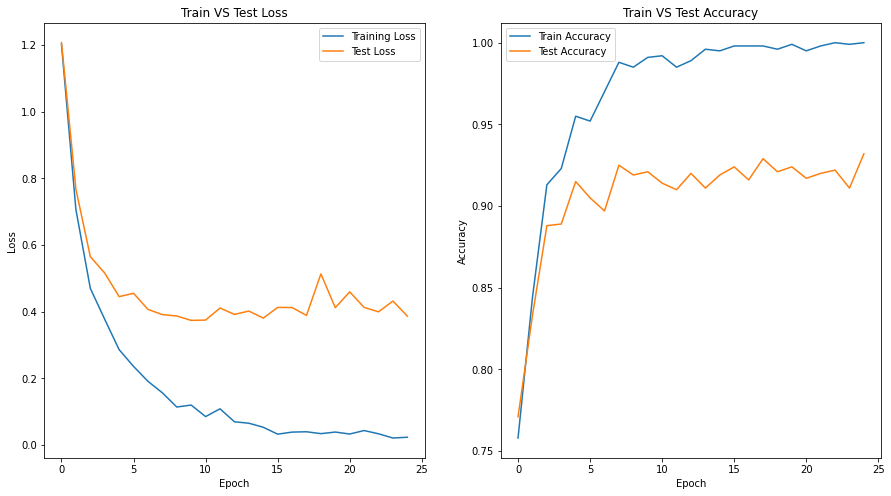

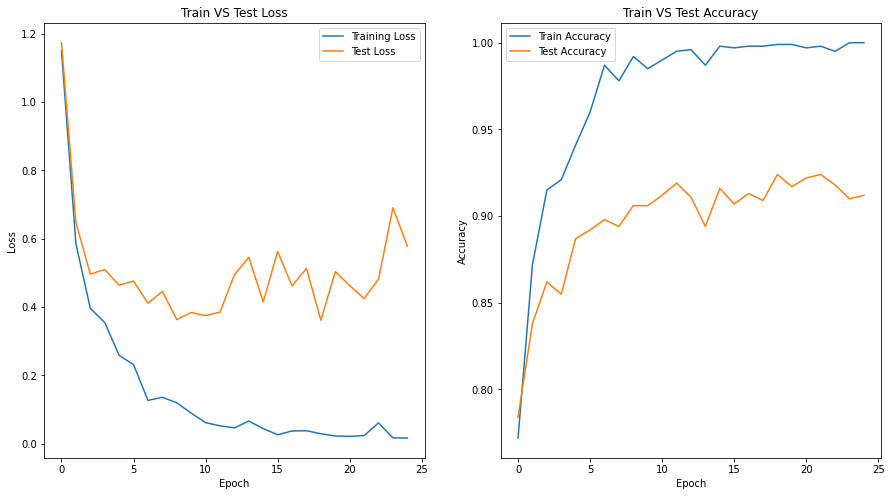

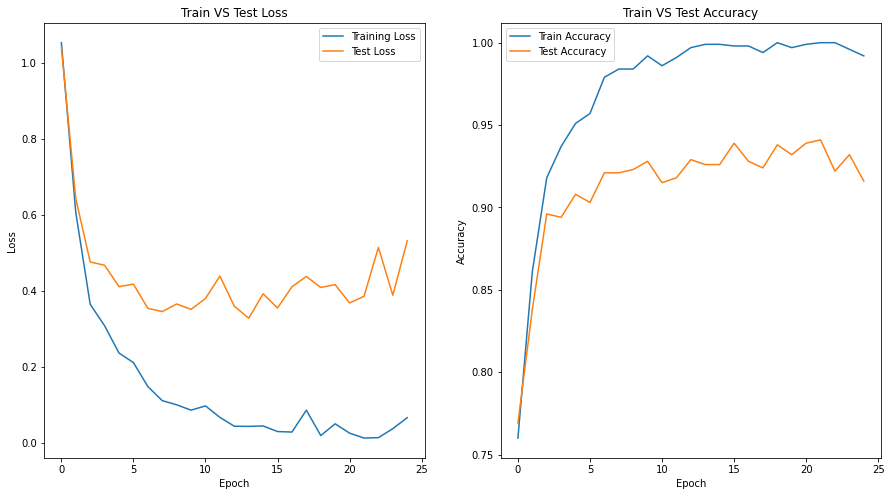

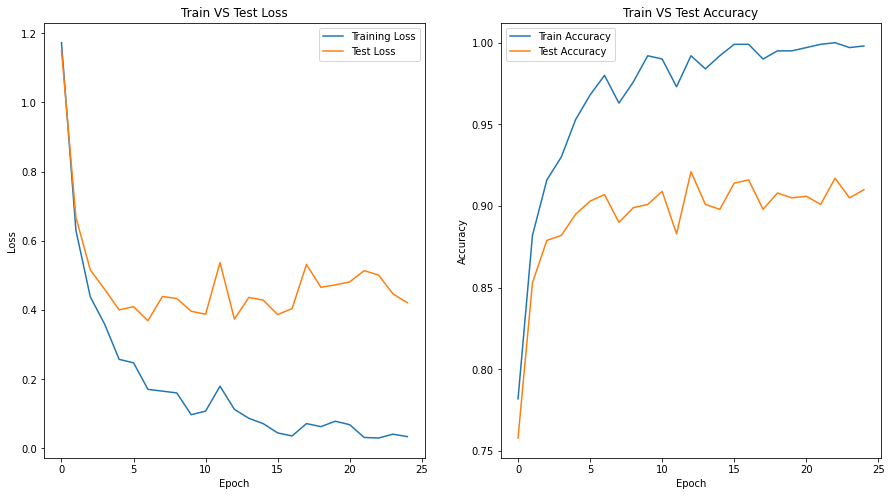

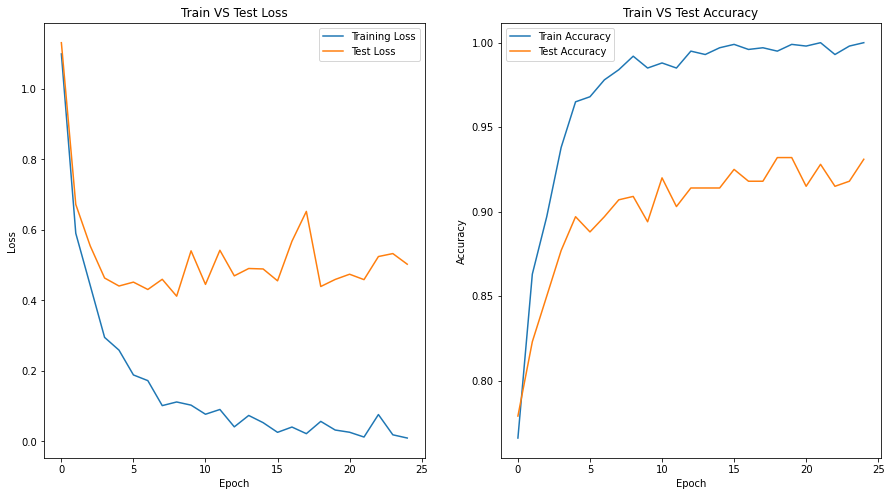

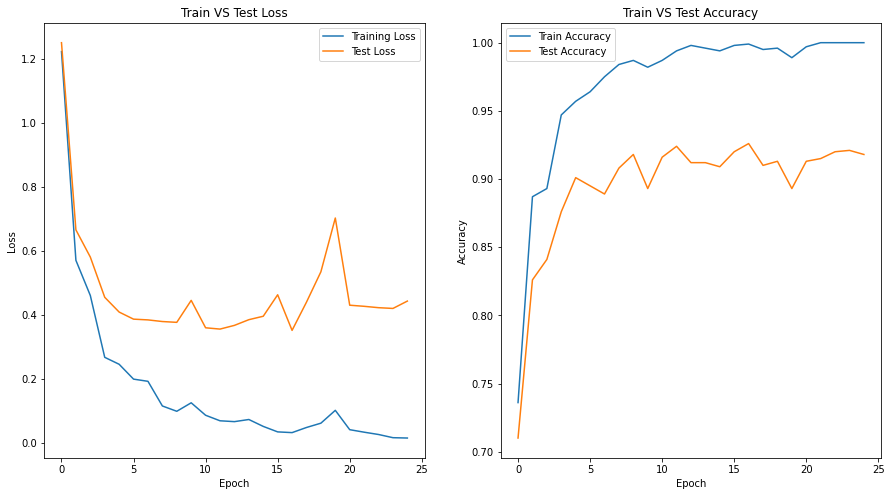

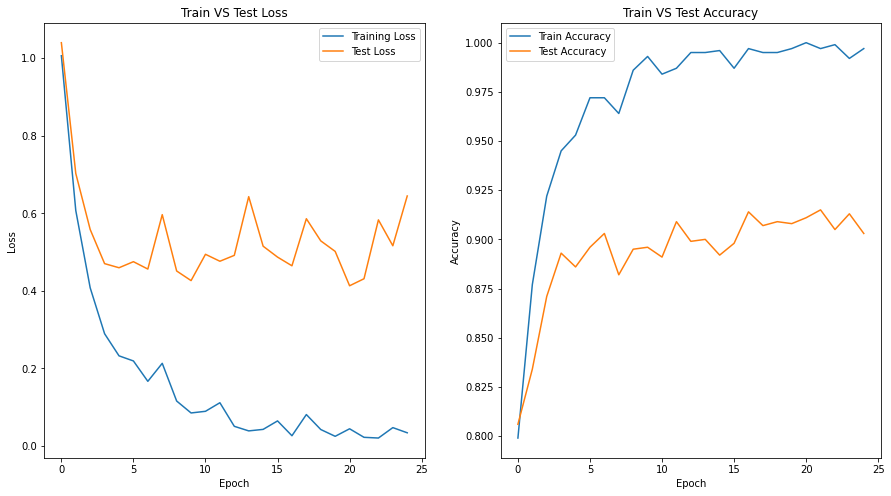

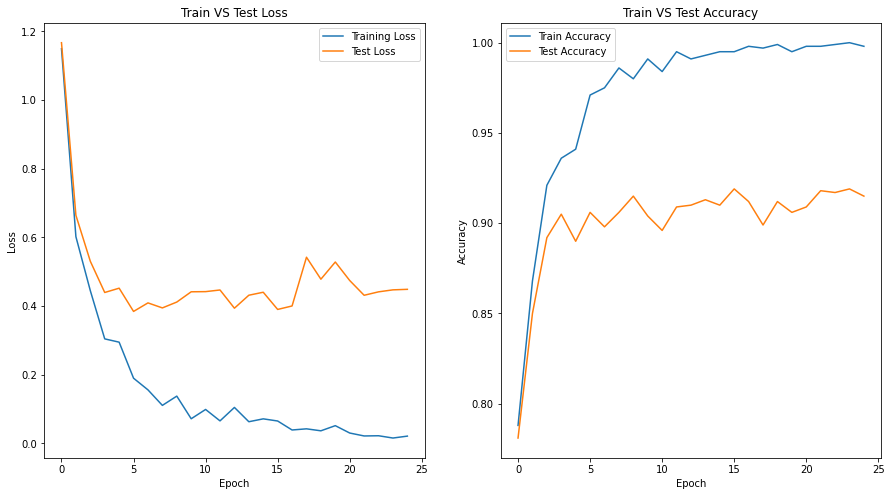

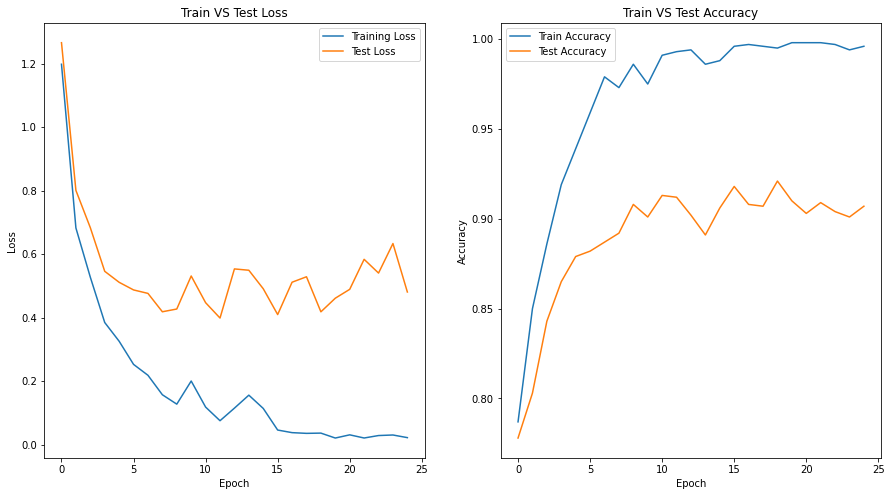

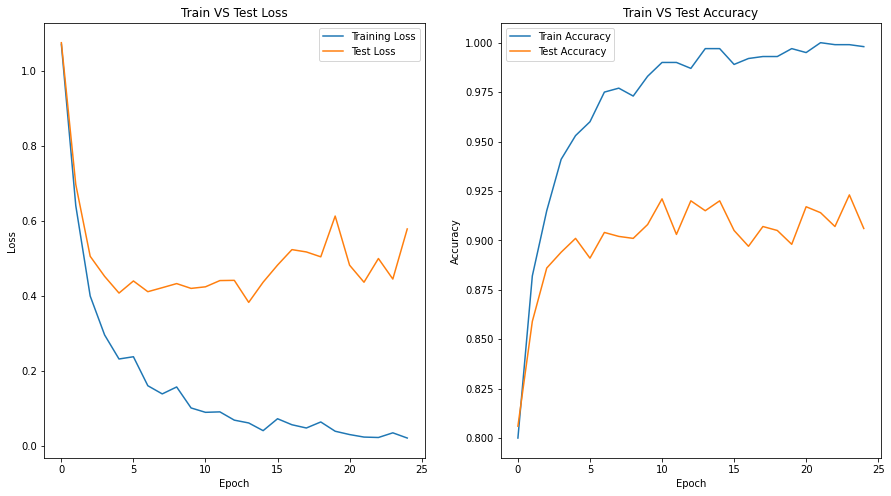

In [11]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing_auxiliary_loss()
    # train the model
    my_model.trainer(train_input, train_target,train_classes, test_input, test_target, test_classes)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [12]:
# print out the deviation and mean value of the training and testing errors
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error:',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.0023853778595524632
The standard deviation of test error: 0.009370157374575078
The mean of train error: 0.00209999680519104
The mean of test error: 0.08499999642372132


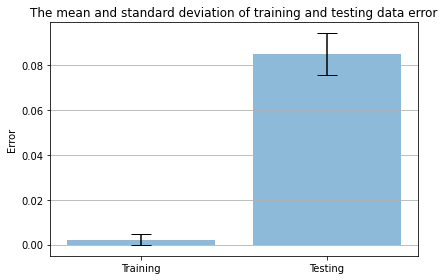

In [13]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors), np.mean(test_errors)]
stds = [np.std(train_errors), np.std(test_errors)]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data error')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()